In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.signal import butter, filtfilt, convolve
import mne

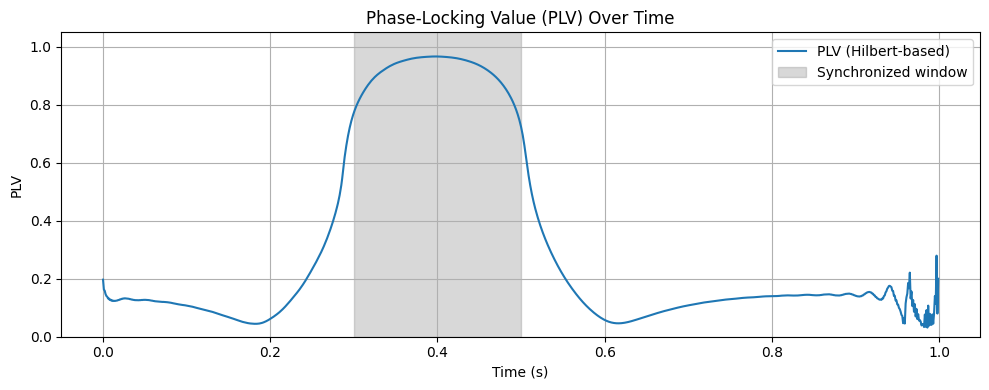

In [ ]:
# Compute Phase-Locking Value (PLV) 

# ==== Step 0: Set Parameters ====
fs = 1000              # Sampling frequency (Hz)
duration = 1.0         # Trial duration (seconds)
n_trials = 50          # Number of trials
n_samples = int(fs * duration)
time = np.arange(0, duration, 1/fs)
freq = 40              # Frequency of interest (Hz)

# ==== Step 1: Simulate signals with synchronized bursts ====
# Create a bell window to enforce synchrony during 300–500ms
bell = np.zeros_like(time)
bell[(time >= 0.3) & (time <= 0.5)] = 1

# Create random phase for each trial
base_phase = np.random.uniform(0, 2*np.pi, size=n_trials)
# s1 = clean 40 Hz oscillation
s1_trials = np.array([np.sin(2 * np.pi * freq * time + p) for p in base_phase])

# s2 = 40 Hz signal with same phase during bell, random otherwise
s2_trials = np.array([
    bell * np.sin(2 * np.pi * freq * time + p) + (1 - bell) * np.sin(2 * np.pi * freq * time + np.random.uniform(0, 2*np.pi))
    for p in base_phase ])


# ==== Step 2: Bandpass Filter using Butterworth filter ====
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return np.array([filtfilt(b, a, trial) for trial in data])

s1_filtered = bandpass_filter(s1_trials, freq - 2, freq + 2, fs)
s2_filtered = bandpass_filter(s2_trials, freq - 2, freq + 2, fs)

from scipy.signal import hilbert

# Apply Hilbert transform to each trial to get analytic signal
analytic_s1 = np.array([hilbert(trial) for trial in s1_filtered])
analytic_s2 = np.array([hilbert(trial) for trial in s2_filtered])

# Extract instantaneous phase
phase1 = np.angle(analytic_s1)
phase2 = np.angle(analytic_s2)

# Compute phase difference u(t,n) = phase1 - phase2
phase_diff = phase1 - phase2

# Compute PLV over trials at each time point
plv = np.abs(np.mean(np.exp(1j * phase_diff), axis=0))

# Plot 
plt.figure(figsize=(10, 4))
plt.plot(time, plv, label='PLV (Hilbert-based)')
plt.axvspan(0.3, 0.5, color='gray', alpha=0.3, label='Synchronized window')
plt.title('Phase-Locking Value (PLV) Over Time')
plt.xlabel('Time (s)')
plt.ylabel('PLV')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



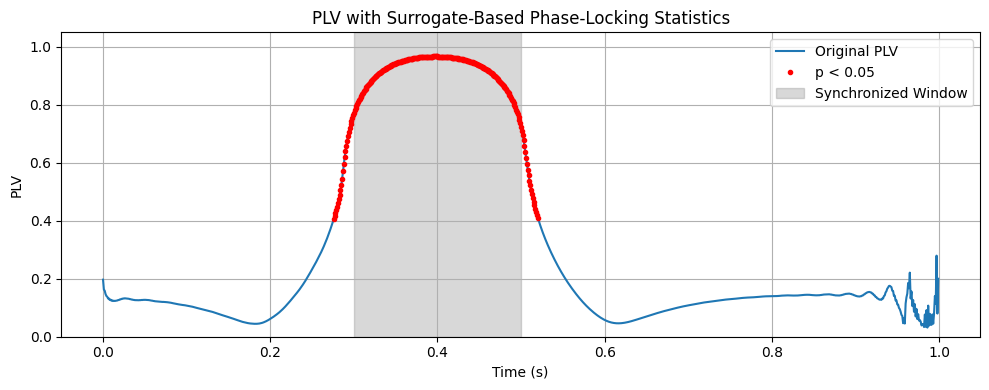

In [3]:
# Compute Phase locking statistics (PLS)
# H0: The phase difference between signals 1 and 2 is independent across trials (i.e., no real coupling).

# ==== Step 3: Generate Surrogate PLV Distributions ====
n_surrogates = 200  # Number of surrogate shuffles
surrogate_plvs = []
# Progress bar to track iterations
for _ in range(n_surrogates):

    # Step 3a: Shuffle the trial order of s2
    shuffled_indices = np.random.permutation(n_trials)
    phase2_shuffled = phase2[shuffled_indices, :]  # trial-wise shuffle

    # Step 3b: Compute phase difference with shuffled s2
    phase_diff_surrogate = phase1 - phase2_shuffled

    # Step 3c: Compute PLV for the surrogate
    surrogate_plv = np.abs(np.mean(np.exp(1j * phase_diff_surrogate), axis=0))
    surrogate_plvs.append(surrogate_plv)


# Step 3d: Convert list to 2D array 
surrogate_plvs = np.array(surrogate_plvs)  # shape: (n_surrogates, n_samples)


# ==== Step 4: Compute Phase-Locking Statistics (PLS) ====
# Step 4a: Take max PLV from each surrogate across time
surrogate_max_per_trial = np.max(surrogate_plvs, axis=1)  # shape: (n_surrogates,)

# Step 4b: For each time point, compute p-value:
pls = np.array([
    np.mean(surrogate_max_per_trial >= plv_t)
    for plv_t in plv
])  # shape: (n_samples,)

# Step 4c: Mark significant points
significant_mask = pls < 0.05


# Plot 
plt.figure(figsize=(10, 4))
plt.plot(time, plv, label='Original PLV')
plt.plot(time[significant_mask], plv[significant_mask], 'r.', label='p < 0.05')
plt.axvspan(0.3, 0.5, color='gray', alpha=0.3, label='Synchronized Window')
plt.title('PLV with Surrogate-Based Phase-Locking Statistics')
plt.xlabel('Time (s)')
plt.ylabel('PLV')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

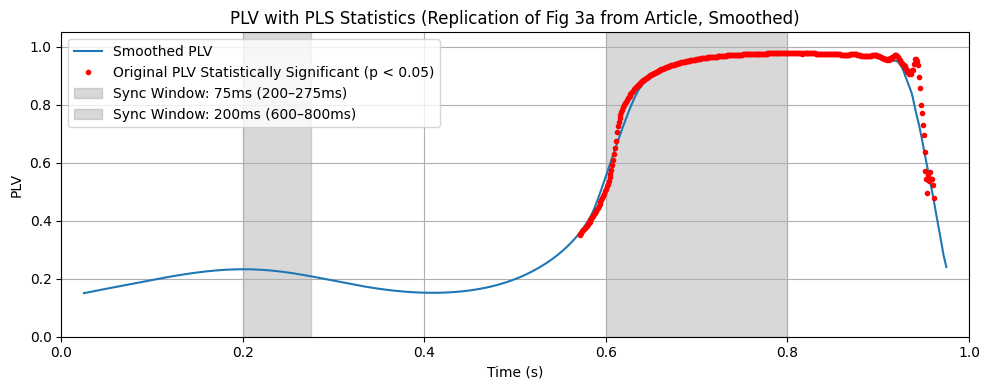

In [4]:
# Replication of Article Simulation for PLV and PLS 

# === Step 0: Set Parameters ===
freq = 43              # Frequency of interest (Hz), as specified in the article for this simulation (43 Hz).

# === Step 1: Simulate Signals with Synchronization Windows ===
# We create two signals (s1 and s2) simulating neuro-electric data, where s2 is synchronized

# Define the synchronization windows:
# First window: 75 milliseconds (ms) between 200ms and 275ms.
# Second window: 200 milliseconds (ms) between 600ms and 800ms.
sync_window = np.zeros_like(time)
sync_window[(time >= 0.2) & (time < 0.275)] = 1 # First synchronization window
sync_window[(time >= 0.6) & (time < 0.8)] = 1   # Second synchronization window

# Generate a random base phase for each trial for s1. This will be the common phase in synchronized windows.
base_phase_s1 = np.random.uniform(0, 2 * np.pi, size=n_trials)

# Generate independent random phases for the unsynchronized parts of s2.
independent_phases_s2 = np.random.uniform(0, 2 * np.pi, size=n_trials)

# s1: Pure sine wave signal at the frequency of interest (freq), with a random initial phase for each trial.
s1_trials = np.array([
    np.sin(2 * np.pi * freq * time + p)
    for p in base_phase_s1
])

# s2: Sine wave signal at the frequency of interest.
# - During the `sync_window` (when `sync_window` is 1), the phase of s2 is identical to that of s1.
# - Outside the `sync_window` (when `sync_window` is 0), the phase of s2 is random and independent
# for each trial (i.e., `independent_phases_s2[i]` serves as the base phase for trial i in the unsynchronized parts).
# This ensures the PLV outside the synchronization windows is low but not entirely zero
s2_trials = np.array([
    sync_window * np.sin(2 * np.pi * freq * time + base_phase_s1[i]) +
    (1 - sync_window) * np.sin(2 * np.pi * freq * time + independent_phases_s2[i])
    for i in range(n_trials)
])

# --- Explanation: Signal Simulation ---
# This simulation mimics a scenario where two brain regions synchronize their activity for brief periods.
# The simulated signals allow us to test the sensitivity of PLV and PLS in detecting true synchronization.
# The generation of `s2_trials` ensures that even in unsynchronized parts, the signal maintains an oscillatory
# structure, but without a fixed phase relationship to s1, leading to a low but non-zero PLV outside synchronization windows.

# === Step 2: Bandpass Filter ===
# Apply bandpass filtering (41-45Hz) to the signals.
s1_filtered = bandpass_filter(s1_trials, freq - 2, freq + 2, fs)
s2_filtered = bandpass_filter(s2_trials, freq - 2, freq + 2, fs)

# === Step 3: Extract Instantaneous Phase using Hilbert Transform ===
# We use the Hilbert transform to extract the instantaneous phase of each filtered signal.

analytic_s1 = np.array([hilbert(trial) for trial in s1_filtered])
analytic_s2 = np.array([hilbert(trial) for trial in s2_filtered])

# Extract the instantaneous phase (the angle of the complex number).
phase1 = np.angle(analytic_s1)
phase2 = np.angle(analytic_s2)

# === Step 4: Compute Phase Difference ===
# The phase difference between the two signals is the basis for PLV calculation.
phase_diff = phase1 - phase2

# If two signals are synchronized, their phase difference will be constant or nearly constant.

# === Step 5: Compute Phase-Locking Value (PLV) ===
# Calculate the PLV across trials for each time point, as defined in the article:
plv = np.abs(np.mean(np.exp(1j * phase_diff), axis=0))

# === Step 6: Generate Surrogate Data and Compute their PLV Distributions ===
# We shuffle the trial order of s2 to "break" any true synchronization,
# and create a distribution of PLV values obtained by chance.
n_surrogates = 200  # Number of surrogate shuffles.
surrogate_plvs = []

for _ in range(n_surrogates):
    shuffled_indices = np.random.permutation(n_trials)
    phase2_shuffled = phase2[shuffled_indices, :]  # Shuffle s2 trials
    phase_diff_surrogate = phase1 - phase2_shuffled
    surrogate_plv = np.abs(np.mean(np.exp(1j * phase_diff_surrogate), axis=0))
    surrogate_plvs.append(surrogate_plv)

surrogate_plvs = np.array(surrogate_plvs)

# --- Explanation: Surrogate Data Generation ---
# This process simulates the null hypothesis (H0), stating that there is no true synchronization between the signals.
# It allows us to compare the observed PLV to what we would expect by chance.

# === Step 7: Compute Phase-Locking Statistics (PLS) ===
# Calculate p-values for each time point by comparing the original PLV to the PLV distribution from the surrogates.
# A p-value is the probability of obtaining a PLV equal to or higher than the observed one, if H0 is true.

surrogate_max_per_trial = np.max(surrogate_plvs, axis=1)

pls = np.array([
    np.mean(surrogate_max_per_trial >= plv_t)
    for plv_t in plv
])

# Mark statistically significant points (p < 0.05).
significant_mask = pls < 0.05


# === Step 8: Plot Results ===
# Plot the original PLV curve, the simulated synchronization windows, and mark the statistically significant points.

# Function for moving average smoothing
def moving_average(data, window_size):
    """Applies a moving average filter to the data."""
    if window_size == 0: return data # Handle window_size of 0 to avoid errors
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply smoothing to the PLV data
smoothing_window_size = 50 # Example window size (adjust as needed, e.g., 50ms for 1000Hz fs)
smoothed_plv = moving_average(plv, smoothing_window_size)
# Adjust time vector for smoothed data
smoothed_time = time[int(smoothing_window_size/2):-int(smoothing_window_size/2) + (1 if smoothing_window_size % 2 == 0 else 0)]

plt.figure(figsize=(10, 4))
plt.plot(smoothed_time, smoothed_plv, label='Smoothed PLV') # Plot the smoothed PLV curve.
# Plot original significant points. Note: For a strict smoothed significance, PLS would need to be re-calculated on smoothed PLV.
# For visual representation, we mark original significant points.
plt.plot(time[significant_mask], plv[significant_mask], 'r.', label='Original PLV Statistically Significant (p < 0.05)')
plt.axvspan(0.2, 0.275, color='gray', alpha=0.3, label='Sync Window: 75ms (200–275ms)')
plt.axvspan(0.6, 0.8, color='gray', alpha=0.3, label='Sync Window: 200ms (600–800ms)')
plt.title('PLV with PLS Statistics (Replication of Fig 3a from Article, Smoothed)')
plt.xlabel('Time (s)')
plt.ylabel('PLV')
plt.ylim(0, 1.05)
plt.xlim(0, duration) # Ensure x-axis covers the full duration
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
